Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [84]:
df.shape

(421, 59)

In [85]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [86]:
df.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [0]:
ingredients = ['Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']

In [0]:
for ing in ingredients:
  df[ing] = df[ing].map({'x':1, 'X':1})
  df[ing] = df[ing].fillna(value=0)

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, random_state=0)

In [90]:
train.shape, val.shape

((315, 59), (106, 59))

# basline

In [91]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.549206
True     0.450794
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

In [93]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.5492063492063493

In [94]:
y_train.value_counts(normalize=True)

False    0.549206
True     0.450794
Name: Great, dtype: float64

# X_train, y_train, X_val, y_val

In [95]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,0.0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,California,1/24/2016,3.5,3.3,0.0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,Carnitas,1/24/2016,NaN,NaN,0.0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,Asada,1/24/2016,NaN,NaN,0.0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,California,1/27/2016,4.0,3.8,1.0,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [96]:
features = df.drop(columns=['Date', 'Great']).columns
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((315, 57), (106, 57))

#one hot encode

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [0]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)

X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)

In [99]:
X_train_enc.shape, X_val_enc.shape

((315, 61), (106, 61))

In [100]:
X_train_enc.head()

,Burrito_Other,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Surf & Turf,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
302,1,0,0,0,0,NaN,NaN,0.0,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,1,0,0,0,0,NaN,NaN,0.0,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0,1,0,0,0,4.0,4.6,0.0,7.14,3.5,NaN,NaN,20.0,23.0,0.84,4.0,2.0,4.0,5.0,4.0,2.0,4.0,4.50,5.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,0,1,0,0,0,3.5,4.4,0.0,6.50,4.0,NaN,NaN,19.5,21.0,0.68,3.0,2.5,2.5,3.0,4.0,3.5,2.5,3.00,5.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,0,1,0,0,0,NaN,NaN,0.0,8.99,4.0,NaN,NaN,24.0,22.0,0.92,4.5,5.0,3.5,4.0,4.0,4.0,NaN,2.50,1.5,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#impute

In [103]:
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((315, 61), (106, 61))

In [0]:
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns=X_val_enc.columns)

In [108]:
X_train_imp.head()

,Burrito_Other,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Surf & Turf,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,1.0,0.0,0.0,0.0,0.0,3.843284,4.192537,0.0,6.60,3.503514,559.222222,0.670471,20.5,21.5,0.75,4.0,2.0,3.627467,4.000000,3.605645,4.6,4.200000,3.75,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,3.843284,4.192537,0.0,6.00,1.000000,559.222222,0.670471,17.0,20.5,0.57,5.0,4.0,3.500000,3.581629,4.000000,4.0,2.000000,2.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,4.000000,4.600000,0.0,7.14,3.500000,559.222222,0.670471,20.0,23.0,0.84,4.0,2.0,4.000000,5.000000,4.000000,2.0,4.000000,4.50,5.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,3.500000,4.400000,0.0,6.50,4.000000,559.222222,0.670471,19.5,21.0,0.68,3.0,2.5,2.500000,3.000000,4.000000,3.5,2.500000,3.00,5.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,3.843284,4.192537,0.0,8.99,4.000000,559.222222,0.670471,24.0,22.0,0.92,4.5,5.0,3.500000,4.000000,4.000000,4.0,3.380537,2.50,1.5,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#scale

In [0]:
scalar = StandardScaler()
X_train_sc = scalar.fit_transform(X_train_imp)
X_val_sc = scalar.transform(X_val_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_enc.columns)

In [109]:
X_train_sc.head()

,Burrito_Other,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Surf & Turf,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,1.374739,-0.832796,-0.260378,-0.347845,-0.280655,-3.928097e-15,5.634795e-15,-0.246183,-0.362934,-5.330580e-16,0.0,5.605254e-15,0.239370,-0.455926,-0.326096,0.552619,-1.870926,5.330799e-16,5.276070e-01,-4.551565e-16,1.085381,9.157569e-01,0.157567,0.898943,-0.29361,-0.127,-0.860425,-0.827340,-0.753103,-0.784465,-0.681994,-0.539429,-0.36482,-0.231326,-0.246183,-0.079936,-0.293610,-0.287183,-0.181071,-0.11341,-0.127,-0.056433,-0.098058,-0.306186,-0.127,-0.171499,-0.190221,-0.079936,-0.139347,-0.056433,-0.11341,-0.079936,0.0,0.0,-0.11341,-0.056433,-0.079936,-0.056433,-0.190221,-0.056433,-0.056433
1,1.374739,-0.832796,-0.260378,-0.347845,-0.280655,-3.928097e-15,5.634795e-15,-0.246183,-0.872795,-3.005068e+00,0.0,5.605254e-15,-1.841522,-1.129557,-1.732784,1.836358,0.218716,-1.530101e-01,-5.600407e-16,4.041826e-01,0.516726,-1.542762e+00,-1.858333,0.898943,-0.29361,-0.127,-0.860425,-0.827340,-0.753103,-0.784465,-0.681994,-0.539429,-0.36482,-0.231326,-0.246183,-0.079936,-0.293610,-0.287183,-0.181071,-0.11341,-0.127,-0.056433,-0.098058,-0.306186,-0.127,-0.171499,-0.190221,-0.079936,-0.139347,-0.056433,-0.11341,-0.079936,0.0,0.0,-0.11341,-0.056433,-0.079936,-0.056433,-0.190221,-0.056433,-0.056433
2,-0.727411,1.200775,-0.260378,-0.347845,-0.280655,6.931009e-01,2.585031e+00,-0.246183,0.095942,-4.218447e-03,0.0,5.605254e-15,-0.057901,0.554521,0.377248,0.552619,-1.870926,4.471845e-01,1.788706e+00,4.041826e-01,-1.378793,6.922552e-01,1.021524,0.898943,-0.29361,-0.127,1.162216,-0.827340,1.327840,1.274755,1.466288,1.853812,-0.36482,-0.231326,-0.246183,-0.079936,3.405877,-0.287183,-0.181071,-0.11341,-0.127,-0.056433,-0.098058,-0.306186,-0.127,-0.171499,-0.190221,-0.079936,-0.139347,-0.056433,-0.11341,-0.079936,0.0,0.0,-0.11341,-0.056433,-0.079936,-0.056433,-0.190221,-0.056433,-0.056433
3,-0.727411,1.200775,-0.260378,-0.347845,-0.280655,-1.518221e+00,1.316188e+00,-0.246183,-0.447911,5.959515e-01,0.0,5.605254e-15,-0.355171,-0.792741,-0.873141,-0.731120,-1.348515,-1.353399e+00,-7.334925e-01,4.041826e-01,0.042846,-9.840074e-01,-0.706390,0.898943,-0.29361,-0.127,1.162216,-0.827340,-0.753103,1.274755,1.466288,1.853812,-0.36482,4.322904,-0.246183,-0.079936,-0.293610,-0.287183,-0.181071,-0.11341,-0.127,-0.056433,-0.098058,-0.306186,-0.127,-0.171499,-0.190221,-0.079936,-0.139347,-0.056433,-0.11341,-0.079936,0.0,0.0,-0.11341,-0.056433,-0.079936,-0.056433,-0.190221,-0.056433,-0.056433
4,-0.727411,1.200775,-0.260378,-0.347845,-0.280655,-3.928097e-15,5.634795e-15,-0.246183,1.668014,5.959515e-01,0.0,5.605254e-15,2.320261,-0.119110,1.002443,1.194489,1.263537,-1.530101e-01,5.276070e-01,4.041826e-01,0.516726,4.962734e-16,-1.282361,-2.177571,-0.29361,-0.127,1.162216,1.208692,1.327840,1.274755,1.466288,1.853812,-0.36482,-0.231326,-0.246183,-0.079936,-0.293610,-0.287183,-0.181071,-0.11341,-0.127,-0.056433,-0.098058,-0.306186,-0.127,-0.171499,-0.190221,-0.079936,-0.139347,-0.056433,-0.11341,-0.079936,0.0,0.0,-0.11341,-0.056433,-0.079936,-0.056433,-0.190221,-0.056433,-0.056433


In [112]:
X_train_sc['Yelp'].std()

1.0015910909027679

# Logistic Regression

In [118]:
model = LogisticRegressionCV(max_iter=300)
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [119]:
model.score(X_val_sc, y_val)

0.8113207547169812

In [121]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Burrito_Other         -0.149676
Burrito_California     0.115303
Burrito_Carnitas       0.042454
Burrito_Asada          0.086957
Burrito_Surf & Turf   -0.087765
                         ...   
Bacon                  0.096586
Sushi                  0.086767
Avocado               -0.073985
Corn                  -0.008058
Zucchini               0.049066
Length: 61, dtype: float64

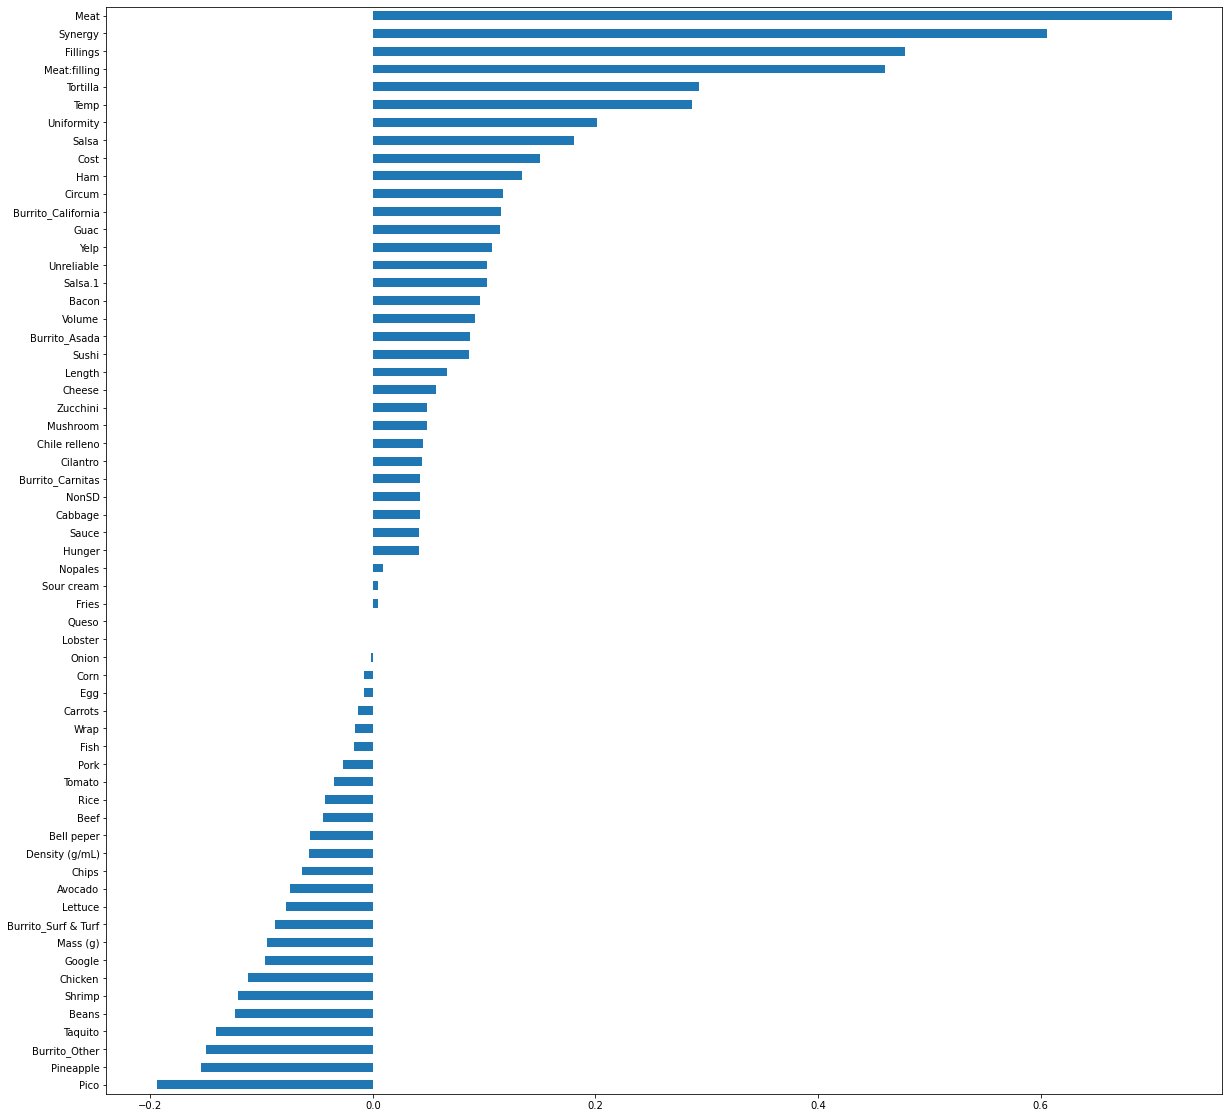

In [129]:
coefs.sort_values().plot.barh(figsize=(20,20))